## Welcome to an initial exploration of a Zillow dataset for Single-Family Properties in Southern California, specifically Los Angeles, Orange, and Ventura Counties

Rich Alcabes, Zillow DS Team Member

In [1]:
#standard ds imports
import pandas as pd
import numpy as np
#viz and stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
# .py imports
from env import user, pwd,host
import env
import wrangle_zillow as wz
import os
#sklearn imports
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
#CATboost imports
from catboost import CatBoostRegressor

## OVERVIEW and GOALS:

### Using data from 3 counties in the LA metroplex, provide recommendations for refining our current model (MODEL Z) for the target Assessed_Taxable_Value of Single-Family properties involved in a transaction during 2017.

- Provide **RECOMMENDATIONS** for improvements upon MODEL Z.
- Subset a relatively **NOISY** datset to extract possible signal from the noise.
- **REDUCE** dimensionality via selection tools and identify multicolinearity.
- Identify avenues of future exploration and modeling.
- Create a model which explains the greatest amount of the variance in the target feature.

## ACQUISTION and PREP: Features needed for Tax Valuation not Market Valuation
#### beds / baths / sqft / year-built / lotsqft / fips / city 

- Encoded required features
- Removed Outliers; Default 1.5 * IQR except for Beds (1-5) & Baths (1-4)
- Removed rows containing NULL values for important features
- Split data into standard ML subsets (Train/Validate/Test)
- Derived missing Year_Built data from Train and impute into Validate and Test

local version found!


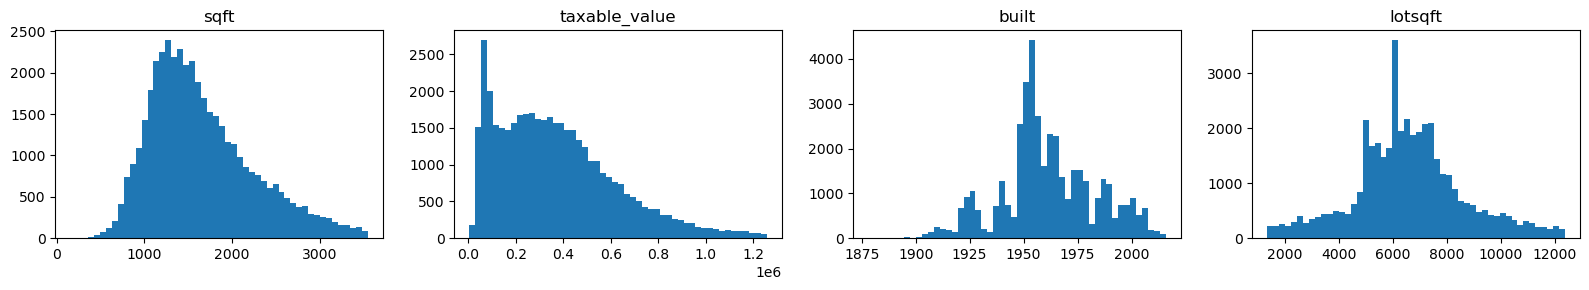

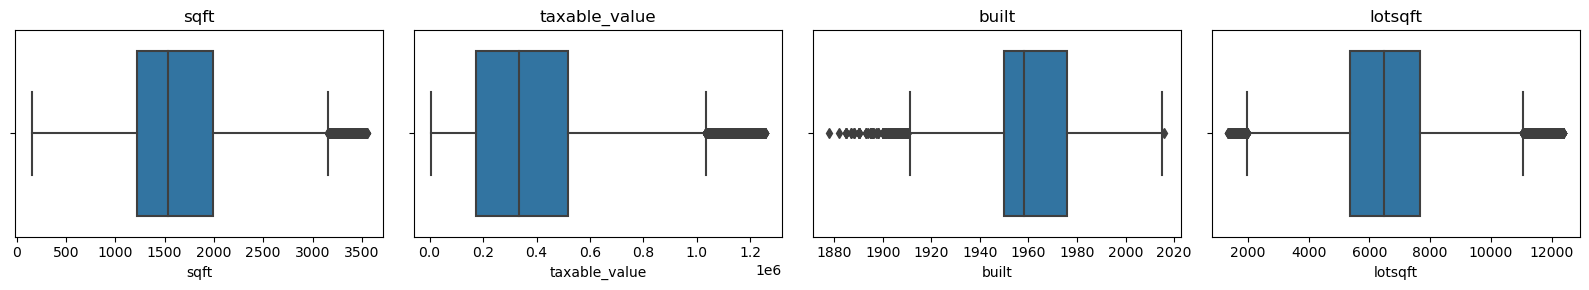

In [2]:
# Acquire/Prep/Split dataset:
train_all,validate_all,test_all = wz.wrangle_zillow()
train_all['fips'] = train_all.fips.astype(int).astype(object)
train_all['beds'] = train_all.beds.astype(int)
# Outputs the distributions of continuous variables

## EXPLORATION and HYPOTHESES:

- Imbalalance in FIPS features?
- Statistically significant difference in means for each **County**, when compared to overall mean?
- Correlation among SQFT, BEDS, and BATHS?
- Distribution of Target feature when subset by County?

### FIPS Datapoints in Train:
- (6037)  LA Cnty:      ~15k
- (6059)  Orange Cnty:  ~ 6k
- (6111)  Ventura Cnty: ~ 2k

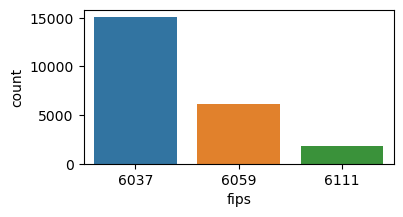

6037    15085
6059     6179
6111     1872
Name: fips, dtype: int64

In [3]:
# Barchart to show disparity in FIPS counts:
plt.figure(figsize=(4,2))
sns.countplot(train_all['fips'])
plt.show()
train_all.fips.value_counts()

In [4]:
#output each mean and overall mean:
print(f'OVERALL: {round(train_all.taxable_value.mean(),0)}')
print(f'LA CNTY: {round(train_all[train_all.fips == 6037].taxable_value.mean(),0)}')
print(f'ORANGE CNTY: {round(train_all[train_all.fips == 6059].taxable_value.mean(),0)}')
print(f'VENTURA CNTY: {round(train_all[train_all.fips == 6111].taxable_value.mean(),0)}')

OVERALL: 370258.0
LA CNTY: 333879.0
ORANGE CNTY: 447286.0
VENTURA CNTY: 409160.0


# LA County Mean vs Overall Mean
## Does a statistically significant difference exist between mean Taxable_Value in LA CNTY and that of the OVERALL sample?
### T-Test Independence 1-sample, 2-tail

## Due to CentralLimitTheorem and large sample size( > 500): assumption of "normality" is no longer necessary

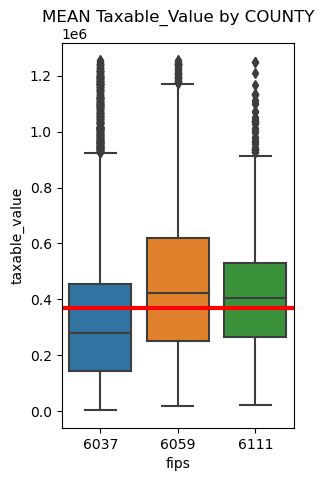

In [5]:
mean = train_all.taxable_value.mean()
plt.figure(figsize=(3,5))
sns.boxplot(data=train_all, y='taxable_value',x='fips')
plt.axhline(y=mean,color='red', linewidth=3)
plt.title('MEAN Taxable_Value by COUNTY',pad=15)
plt.show()

### Mean taxable_value by FIPS:
- OVERALL MEAN: ~ 370k
- (6037)  LA Cnty:      ~ 334k
- (6059)  Orange Cnty:  ~ 447k
- (6111)  Ventura Cnty: ~ 409k





### Hypothesis

- ${H_0}$: No statistically significant difference exists between mean Taxable_Values in LA County and the mean of all counties.
- ${H_a}$: A statistically significant difference exists between mean Taxable_Values in LA County and the mean of all counties.

#### Two-tailed, One-Sample T-Test ANY DIFF in mean between a subset and overall

In [6]:
α = 0.05
lacnty_taxable_values = train_all[train_all.fips == 6037].taxable_value
overall_mean = train_all.taxable_value.mean()
t, p = stats.ttest_1samp(lacnty_taxable_values,overall_mean)
print(t,p,α)
print(f'p = {p:e}')

-18.26322060553196 1.0105590708760435e-73 0.05
p = 1.010559e-73


# with a p-value of close to Zero, Reject the NULL
### A statistically significant difference exists, there is evidence to suggest that the two samples were drawn from two distinct distributions.

---
---
# SQFT vs Baths

## Does a statistically significant correlation exist between SQFT feature and Baths feature values?
### Pearson's R for linear correlation


### Hypothesis

- ${H_0}$: No statistically significant correlation exists between SQFT values in all counties and Baths values in all counties.
- ${H_a}$: A statistically significant correlation exists between SQFT values in all counties and Baths values in all counties.


In [7]:
sqft_col = train_all.sqft
baths_col = train_all.baths
r, p = stats.pearsonr(sqft_col,baths_col)

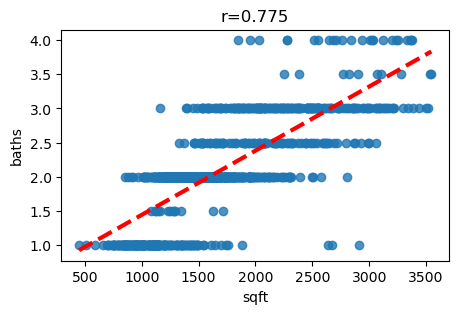

In [8]:
# Depict the relationship between SQFT and Baths
train_1000 = train_all.sample(1000)
plt.figure(figsize=(5,3))
#sns.scatterplot(data=train_1000, x='sqft',y='baths')
sns.regplot(train_1000['sqft'],train_1000['baths'],ci=False,line_kws={'color':'red',
                                                                              'lw':3,
                                                                             'linestyle':'--'})
plt.title(f'r={round(r,3)}')
plt.show()

In [9]:
α = 0.05

print(r,p,α)
print(f'p = {p:e}')

0.7754775107376679 0.0 0.05
p = 0.000000e+00


# with a p-value of Zero, Reject the NULL
### A statistically significant correlation exists, there is evidence to suggest that the observed correlation is due to something other than random sampling.
## r = ~ 0.78

---
---
# SQFT vs Taxable_Value

## Does a statistically significant correlation exist between SQFT feature and Taxable_Value feature values?
### Pearson's R for linear correlation


### Hypothesis

- ${H_0}$: No statistically significant correlation exists between SQFT values in all counties and Taxable_Values in all counties.
- ${H_a}$: A statistically significant correlation exists between SQFT values in all counties and Taxable_Values in all counties.


In [10]:
sqft_col = train_all.sqft
tax_col = train_all.taxable_value
r, p = stats.pearsonr(sqft_col,tax_col)

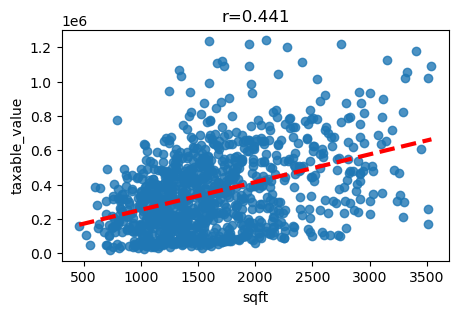

In [11]:
# Depict a representative relationship between SQFT and taxable_value
train_1000 = train_all.sample(1000)
plt.figure(figsize=(5,3))
#sns.scatterplot(data=train_1000, x='sqft',y='taxable_value')
sns.regplot(train_1000['sqft'],train_1000['taxable_value'],ci=False,line_kws={'color':'red',
                                                                              'lw':3,
                                                                             'linestyle':'--'})
plt.title(f'r={round(r,3)}')
plt.show()

In [12]:
α = 0.05

print(r,p,α)
print(f'p = {p:e}')

0.4408769654386143 0.0 0.05
p = 0.000000e+00


# with a p-value of Zero, Reject the NULL
### A statistically significant correlation exists, there is evidence to suggest that the observed correlation is due to something other than random sampling.
## r = ~ 0.44

## Create a Subset for LA County and create a new calculated feature: o_sqft

In [13]:
# Subset the data into LA County ONLY:
train = train_all[train_all['fips'] == 6037]
validate = validate_all[validate_all['fips'] == 6037]
test = test_all[test_all['fips'] == 6037]

### if we need to control for multicollinearity: feature engineering
### o_sqft = SQFT / (BEDS + BATHS)

In [14]:
# Create a feature which combines SQFT-BEDS-BATHS to remove multicolinearity.
train['o_sqft'] = round(train['sqft'] / (train.beds + train.baths),0)
validate['o_sqft'] = round(validate['sqft'] / (validate.beds + validate.baths),0)
test['o_sqft'] = round(test['sqft'] / (test.beds + test.baths),0)

In [15]:
train.head()

,beds,baths,sqft,taxable_value,built,lotsqft,fips,city,o_sqft
49580,5,3.0,3000.0,305487.0,2005.0,6674.0,6037,5534.0,375.0
37700,2,1.0,1194.0,232682.0,1949.0,6702.0,6037,24174.0,398.0
26686,3,2.0,1706.0,92573.0,1951.0,5974.0,6037,118225.0,341.0
20095,3,2.0,1541.0,294404.0,1946.0,6202.0,6037,12447.0,308.0
43704,3,2.0,1308.0,169691.0,1944.0,5460.0,6037,12292.0,262.0


# Evaluate
### Create the following:
- Subset
- Baseline
- Results Report Template

In [16]:
#import sklearn metrics and linear_model
from sklearn.metrics import mean_squared_error,explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import r2_score
#remove the target from X_train and use it to create y_train
X_train,y_train = train.drop(columns='taxable_value'), train[['taxable_value']]
X_validate,y_validate = validate.drop(columns='taxable_value'), validate[['taxable_value']]
X_test,y_test = test.drop(columns='taxable_value'), test[['taxable_value']]
#define features for MODEL 1:
model_1_feats = ['sqft',
                'beds',
                'baths']
X_train_1 = X_train[model_1_feats]
X_validate_1 = X_validate[model_1_feats]
X_test_1 = X_test[model_1_feats]


### Ensure the shape and contents of our LA Subsets:

In [17]:
X_train_1.shape, X_validate_1.shape, X_test_1.shape

((15085, 3), (6370, 3), (5355, 3))

In [18]:
X_train_1.head()

,sqft,beds,baths
49580,3000.0,5,3.0
37700,1194.0,2,1.0
26686,1706.0,3,2.0
20095,1541.0,3,2.0
43704,1308.0,3,2.0



### Revisit distribution of LA subset Target Data

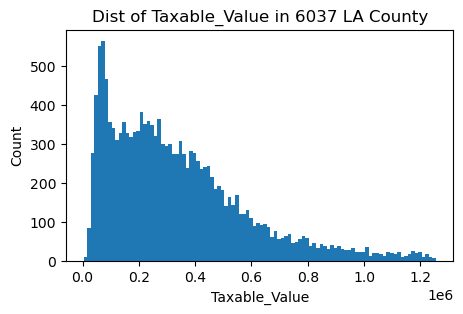

In [19]:
plt.figure(figsize=(5,3))
plt.hist(y_train,bins=100)
plt.title('Dist of Taxable_Value in 6037 LA County')
plt.xlabel("Taxable_Value")
plt.ylabel("Count")

plt.show()


### Baseline Created using Mean Taxable_Value

In [20]:
# convert y_targets into dataframe so that we can append additional columns to it
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
# Predict target_pred_mean-Baseline
target_pred_mean = y_train.taxable_value.mean()
y_train['target_pred_mean'] = round(target_pred_mean,0)
y_validate['target_pred_mean'] = target_pred_mean
#Calculate RMSE for Baseline:
rmse_train_mean = round(mean_squared_error(y_train.taxable_value,
                                y_train.target_pred_mean) ** (.5),1)
rmse_validate_mean = round(mean_squared_error(y_validate.taxable_value, y_validate.target_pred_mean) ** (0.5),1)
print(f"""RMSE using Mean
Train/In-Sample: {round(rmse_train_mean, 1)} 
Validate/Out-of-Sample: {round(rmse_validate_mean, 1)}""")

RMSE using Mean
Train/In-Sample: 244642.7 
Validate/Out-of-Sample: 243038.5



### Construct Results Report Framework

In [21]:
# build a quick df to compare results...will append to this df as needed
metric_df = pd.DataFrame(data=[
    {'model': 'mean_baseline',
     'RMSE_train': rmse_train_mean,
     'RMSE_validate': rmse_validate_mean,
     'R2_validate': explained_variance_score(y_validate.taxable_value,
                                             y_validate.target_pred_mean)
    }
]
)
metric_df

,model,RMSE_train,RMSE_validate,R2_validate
0,mean_baseline,244642.7,243038.5,0.0


## OLS: MODEL 1 (codename: Mandatory Fun) 
- using SQFT, BEDS, BATHS

In [22]:
# MAKE THE THING: create the model object
lm = LinearRegression()
# FIT THE THING: fit the model to training data
OLSmodel = lm.fit(X_train_1, y_train.taxable_value)
# USE THE THING: make a prediction
y_train['target_pred_lm'] = lm.predict(X_train_1)
#Evaluate: RMSE
rmse_train = mean_squared_error(y_train.taxable_value, y_train.target_pred_lm)**(1/2)
# predict validate
y_validate['target_pred_lm'] = lm.predict(X_validate_1)
# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.taxable_value, y_validate.target_pred_lm)**(1/2)
print(f"""RMSE for OLS using LinearRegression
Training/In-Sample:  {rmse_train} 
Validation/Out-of-Sample: {rmse_validate}""")

RMSE for OLS using LinearRegression
Training/In-Sample:  227358.360737476 
Validation/Out-of-Sample: 225182.72442983423


In [23]:
#Append this to the metric_df
metric_df = metric_df.append(
    {'model': 'OLS Mandatory Fun',
     'RMSE_train': round(rmse_train,1),
     'RMSE_validate': round(rmse_validate,1),
     'R2_validate': round(explained_variance_score(y_validate.taxable_value,
                                             y_validate.target_pred_lm),4)
    }, ignore_index=True)
metric_df

,model,RMSE_train,RMSE_validate,R2_validate
0,mean_baseline,244642.7,243038.5,0.0000
1,OLS Mandatory Fun,227358.4,225182.7,0.1415


## OLS: MODEL 1 explains 14.2% of the variation in the target for the LA subset

### A quick peek under the hood reveals the following order of coeficients:

    1. BATHS  24769
    2. SQFT     173
    3. BEDS  -46036

In [24]:
#take a look under the hood 
coef_df = pd.DataFrame({'cols':X_train_1.columns,
              'OLScoef':OLSmodel.coef_})
coef_df

,cols,OLScoef
0,sqft,173.655220
1,beds,-46036.985532
2,baths,24769.383406


### Models which did not make the cut:

    1. OLS Model with one feature: o_sqft ---  sqft / (beds+baths)
    2. OLS Model with one feature: baths
    3. Decision Tree Regressor (max_depth = 3) with all 8 features
    4. Vanilla Decision Tree - OFAF

### Need some insight about feature selection

----
----

## Feature Importance with Select K Best and RFE

In [25]:
# make the thing
kbest = SelectKBest(f_regression,k=4)
# fit the thing
_ = kbest.fit(X_train,y_train.taxable_value)
# statistical f-value:
kbest.scores_
X_train.columns[kbest.get_support()]

Index(['beds', 'baths', 'sqft', 'o_sqft'], dtype='object')

### RFE

In [26]:
# establish a model for RFE to use
model = LinearRegression()
# make an RFE thing
rfe = RFE(model, n_features_to_select=4)
# fit the RFE thing
rfe.fit(X_train,y_train.taxable_value)
rfe_df = pd.DataFrame({
    'rfe_ranking':rfe.ranking_
}, index=X_train.columns)
rfe_df.sort_values('rfe_ranking')

,rfe_ranking
beds,1
baths,1
sqft,1
built,1
o_sqft,2
lotsqft,3
city,4
fips,5


----
----

## Back to Model Building...
## Finally found a Decision Tree Regressor that imporves upon the 14.2%
### Codename: Lucky

In [27]:
# Create and fit the thing
DTRp = DecisionTreeRegressor(max_depth=7)
DTRp.fit(X_train,y_train.taxable_value)
y_train['target_pred_DTRp'] = DTRp.predict(X_train)
DTRp.predict(X_train)
# evaluate: RMSE
rmse_train = mean_squared_error(y_train.taxable_value, y_train.target_pred_DTRp)**(1/2)
# predict validate
y_validate['target_pred_DTRp'] = DTRp.predict(X_validate)
# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.taxable_value, y_validate.target_pred_DTRp)**(1/2)
r2 = r2_score(y_train.taxable_value,y_train.target_pred_DTRp)
print(f"""RMSE for OLS using LinearRegression
Training/In-Sample:  {rmse_train} 
Validation/Out-of-Sample: {rmse_validate}
Train R2 Score: {r2}""")
#Append this to the metric_df
metric_df = metric_df.append(
    {'model': 'DT Regressor: Lucky',
     'RMSE_train': round(rmse_train,1),
     'RMSE_validate': round(rmse_validate,1),
     'R2_validate': round(explained_variance_score(y_validate.taxable_value,
                                             y_validate.target_pred_DTRp),4)
    }, ignore_index=True)

RMSE for OLS using LinearRegression
Training/In-Sample:  214009.03323881174 
Validation/Out-of-Sample: 220606.68644238776
Train R2 Score: 0.23475618464254044


In [28]:
metric_df

,model,RMSE_train,RMSE_validate,R2_validate
0,mean_baseline,244642.7,243038.5,0.0000
1,OLS Mandatory Fun,227358.4,225182.7,0.1415
2,DT Regressor: Lucky,214009.0,220606.7,0.1761


## DTR: Lucky explains 17.7% of the variation in the target for the LA subset

----
----
## Also found a Random Forest Regressor that imporves upon the 14.2%
### Codename: Junior (Seau)

In [29]:
# Create and fit the thing
RFRp = RandomForestRegressor(n_estimators=55, max_depth=10,random_state=2013)
RFRp.fit(X_train,y_train.taxable_value)
y_train['target_pred_RFRp'] = RFRp.predict(X_train)
RFRp.predict(X_train)
#Evaluate: RMSE
rmse_train = mean_squared_error(y_train.taxable_value, y_train.target_pred_RFRp)**(1/2)
#REPEAT STEPS 2-3
# predict validate
y_validate['target_pred_RFRp'] = RFRp.predict(X_validate)
# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.taxable_value, y_validate.target_pred_RFRp)**(1/2)
r2 = r2_score(y_train.taxable_value,y_train.target_pred_RFRp)
print(f"""RMSE for OLS using LinearRegression
Training/In-Sample:  {rmse_train} 
Validation/Out-of-Sample: {rmse_validate}
Train R2 Score: {r2}""")
#Append this to the metric_df
metric_df = metric_df.append(
    {'model': 'RF Regressor: Junior',
     'RMSE_train': round(rmse_train,1),
     'RMSE_validate': round(rmse_validate,1),
     'R2_validate': round(explained_variance_score(y_validate.taxable_value,
                                             y_validate.target_pred_RFRp),4)
    }, ignore_index=True)

RMSE for OLS using LinearRegression
Training/In-Sample:  190455.2690957028 
Validation/Out-of-Sample: 211546.43215037603
Train R2 Score: 0.39393165327984503


In [30]:
metric_df

,model,RMSE_train,RMSE_validate,R2_validate
0,mean_baseline,244642.7,243038.5,0.0000
1,OLS Mandatory Fun,227358.4,225182.7,0.1415
2,DT Regressor: Lucky,214009.0,220606.7,0.1761
3,RF Regressor: Junior,190455.3,211546.4,0.2423


## Random Forest Regressor: Junior explains 24.2% of the variation in the target for the LA subset

----
----
## Also found a CATBoost Regressor that imporves upon the 14.2%
### Codename: Meow

In [31]:
# Create and fit the thing
CATb = CatBoostRegressor(verbose=False,max_depth=4)
CATb.fit(X_train,y_train.taxable_value)
y_train['target_pred_CATb'] = CATb.predict(X_train)
CATb.predict(X_train)
#Evaluate: RMSE
rmse_train = mean_squared_error(y_train.taxable_value, y_train.target_pred_CATb)**(1/2)
#REPEAT STEPS 2-3
# predict validate
y_validate['target_pred_CATb'] = CATb.predict(X_validate)
# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.taxable_value, y_validate.target_pred_CATb)**(1/2)
r2 = r2_score(y_train.taxable_value,y_train.target_pred_CATb)
print(f"""RMSE for OLS using LinearRegression
Training/In-Sample:  {rmse_train} 
Validation/Out-of-Sample: {rmse_validate}
Train R2 Score: {r2}""")
#Append this to the metric_df
metric_df = metric_df.append(
    {'model': 'CATb: Meow',
     'RMSE_train': round(rmse_train,1),
     'RMSE_validate': round(rmse_validate,1),
     'R2_validate': round(explained_variance_score(y_validate.taxable_value,
                                             y_validate.target_pred_CATb),4)
    }, ignore_index=True)

RMSE for OLS using LinearRegression
Training/In-Sample:  196379.19990072717 
Validation/Out-of-Sample: 208172.00277358104
Train R2 Score: 0.3556429410230445


In [32]:
metric_df

,model,RMSE_train,RMSE_validate,R2_validate
0,mean_baseline,244642.7,243038.5,0.0000
1,OLS Mandatory Fun,227358.4,225182.7,0.1415
2,DT Regressor: Lucky,214009.0,220606.7,0.1761
3,RF Regressor: Junior,190455.3,211546.4,0.2423
4,CATb: Meow,196379.2,208172.0,0.2663


## CATBoost Regressor: Meow explains 26.6% of the variation in the target for the LA subset

---
---
# Now that we have some options...focus on FIPS 6111 VENTURA CNTY
### Lets first visualize the target distribution for the VENTRA Subset
### then we can use a RF Regressor and see what we get 

In [33]:
# redefine train, val, test for VENTURA County
train = train_all[train_all['fips'] == 6111]
validate= validate_all[validate_all['fips'] == 6111]
test = test_all[test_all['fips'] == 6111]
X_train,y_train = train.drop(columns='taxable_value'), train[['taxable_value']]
X_validate,y_validate = validate.drop(columns='taxable_value'), validate[['taxable_value']]
X_test,y_test = test.drop(columns='taxable_value'), test[['taxable_value']]
# ensure fips == 6111 and check size of train
X_train['fips'].value_counts()

6111    1872
Name: fips, dtype: int64

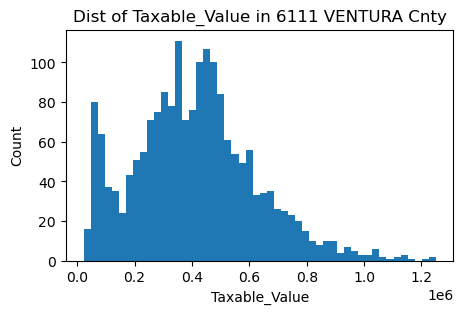

In [34]:
plt.figure(figsize=(5,3))
plt.hist(y_train,bins=50)
plt.title('Dist of Taxable_Value in 6111 VENTURA Cnty')
plt.xlabel("Taxable_Value")
plt.ylabel("Count")
plt.show()

----
----
## RandomForest Regressor for VENTURA County
### Codename: The Body

In [35]:
RFRp = RandomForestRegressor(n_estimators=101, max_depth=7,random_state=2013)
RFRp.fit(X_train,y_train.taxable_value)
y_train['target_pred_RFRp'] = RFRp.predict(X_train)
RFRp.predict(X_train)
#Evaluate: RMSE
rmse_train = mean_squared_error(y_train.taxable_value, y_train.target_pred_RFRp)**(1/2)
#REPEAT STEPS 2-3
# predict validate
y_validate['target_pred_RFRp'] = RFRp.predict(X_validate)
# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.taxable_value, y_validate.target_pred_RFRp)**(1/2)
r2 = r2_score(y_train.taxable_value,y_train.target_pred_RFRp)
print(f"""RMSE for OLS using LinearRegression
Training/In-Sample:  {rmse_train} 
Validation/Out-of-Sample: {rmse_validate}
R2_train: {r2}
R2_validate: {explained_variance_score(y_validate.taxable_value,
                                              y_validate.target_pred_RFRp)}
""")
#Append this to the metric_df
metric_df = metric_df.append(
    {'model': 'RF Regressor VENTURA',
     'RMSE_train': round(rmse_train,1),
     'RMSE_validate': round(rmse_validate,1),
     'R2_validate': round(explained_variance_score(y_validate.taxable_value,
                                             y_validate.target_pred_RFRp),4)
    }, ignore_index=True)

RMSE for OLS using LinearRegression
Training/In-Sample:  131865.2945489587 
Validation/Out-of-Sample: 159461.61450915763
R2_train: 0.6185596369114599
R2_validate: 0.4200587105793071



In [36]:
metric_df

,model,RMSE_train,RMSE_validate,R2_validate
0,mean_baseline,244642.7,243038.5,0.0000
1,OLS Mandatory Fun,227358.4,225182.7,0.1415
2,DT Regressor: Lucky,214009.0,220606.7,0.1761
3,RF Regressor: Junior,190455.3,211546.4,0.2423
4,CATb: Meow,196379.2,208172.0,0.2663
5,RF Regressor VENTURA,131865.3,159461.6,0.4201


## Random Forest Regressor: The Body explains 42.0% of the variation in the target for the VENTURA subset

----
----
# Findings, Takeaways, and Recommendations:
- Taxes assessed at County Level.  Adjusting the level of **GRANULARITY** to match will improve modeling.
- Possible Bi-Modality in multiple counties, but most prevalent in LA County.  Investigate!
- Without **DOMAIN KNOWLEDGE**, no conclusions are valid.
- Significant differences in mean Taxable_Value and dataset homogeneity exist within each county as well as within each City ID.
- Better features related to Tax Policy and NOT Market Valuation are needed, posssibly digested GEO data, etc...
- More domain knowledge required about Socio-Economic Status (SES) of neighboorhoods needed, tax policy of each county needed.
- Apply different algorithms such as GradientBoost, XGBoost, ADABoost, and other non-tree-based regressors such as GLM,Regularized LM, Support Vector Regressors.
- Optimize Hyperparameters in a more programmatic way.
- **Why haven't I run any of this on test dataset?**  We are not yet close enough to optimal solution.

Rich Alcabes, Zillow DS Team